# Import necessary libraries and modules

In [1]:
from project_files.utils import logging
import tensorboard as tb
import torch
import torch.nn as nn
import numpy as np
from torchvision import transforms
import project_files.training as training
from project_files.data_handling import show_image, get_image_folder, get_CIFAR10_split
import matplotlib.pyplot as plt
from PIL import Image
import pytorch_lightning as pl
import torchmetrics
import datasets


/usr/local/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Define data preparation pipeline

In [2]:
resolution = 112
num_classes = 3

batch_size = 32
num_workers = 2
num_epochs = 30
learning_rate = 3e-4
weight_decay = 1e-4
width = 64

In [16]:
class DataLoaderModule(pl.LightningDataModule):
    def __init__(self):
        super().__init__()
        self.train_transform = transforms.Compose([
            # transforms.Resize(size=resolution, antialias=True),
            # transforms.CenterCrop(size=resolution),
            transforms.RandomResizedCrop(size=resolution, scale=(0.25, 1.0), antialias=True),
            transforms.RandomHorizontalFlip(),
            transforms.RandomRotation(15),  # Random rotation within [-15, 15] degrees
            transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),  # Random color adjustments
            transforms.ToTensor(),
            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
        ])
        self.val_transform = transforms.Compose([
            transforms.Resize(size=resolution, antialias=True),
            transforms.CenterCrop(size=resolution),
            transforms.ToTensor(),
            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))

        ])
        
    def preprocess_train(self, batch):
        batch["img"] = [self.train_transform(image) for image in batch["img"]]
        return batch

    def preprocess_val(self, batch):
        batch["img"] = [self.val_transform(image) for image in batch["img"]]
        return batch


 

    def setup(self, stage=None):
        self.training_set = datasets.load_dataset(
            "cifar10", split="train"
        ).with_transform(self.preprocess_train)
        self.validation_set = datasets.load_dataset(
            "cifar10", split="test"
        ).with_transform(self.preprocess_val)

    def train_dataloader(self):
        return torch.utils.data.DataLoader(
            self.train_dataset,
            batch_size=batch_size,
            num_workers=num_workers,
            pin_memory=True,
            drop_last=True,
            shuffle=True,
        )

    def val_dataloader(self):
        return torch.utils.data.DataLoader(
            self.val_dataset,
            batch_size=batch_size,
            num_workers=num_workers,
            pin_memory=True,
        )

    def test_dataloader(self):
        return self.val_dataloader()

In [17]:
datamodule = DataLoaderModule()
datamodule.prepare_data()
datamodule.setup()

# Data details
## Images from training set

In [18]:
def visualize_images(dataset, num_images, num_augmentations):
    class_names = ["airplane", "automobile", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck"]
    plt.figure(figsize=(num_augmentations * 2, num_images * 2))
    for row in range(num_images):
        for column in range(num_augmentations):
            image = dataset[row]["img"]
            label = dataset[row]["label"]
            plt.subplot(num_images, num_augmentations, num_augmentations * row + column + 1)
            plt.imshow(image.cpu().permute(1, 2, 0).numpy())
            if column == 0:
                plt.title(class_names[label], loc="left")
            plt.axis("off")
    plt.tight_layout()
    plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

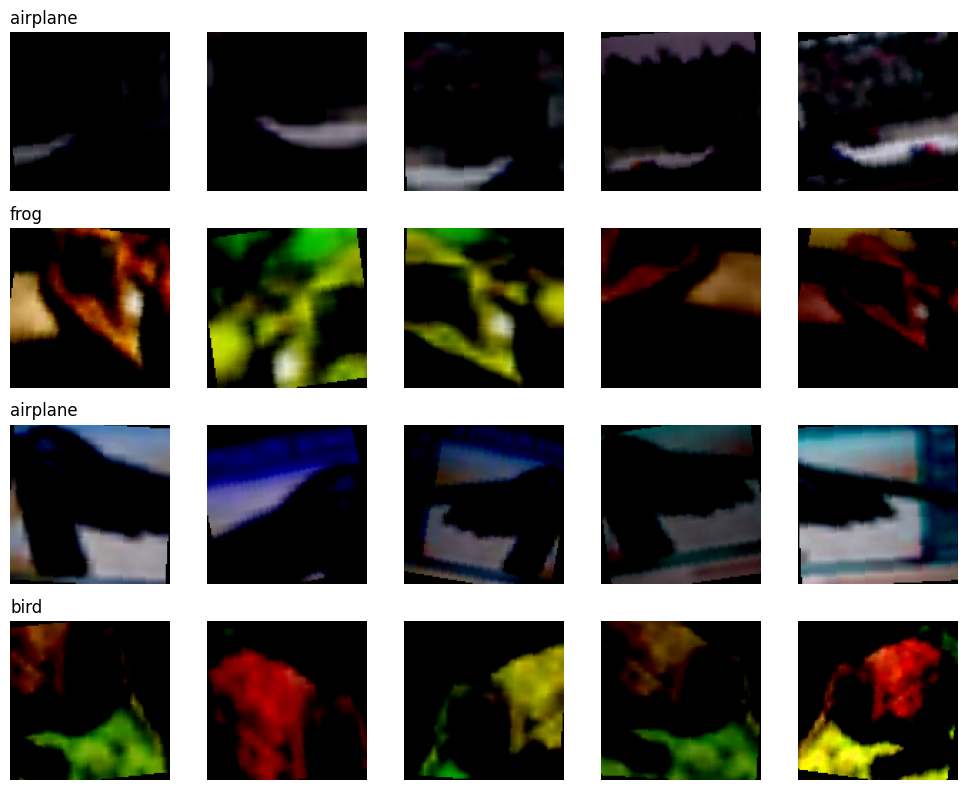

In [19]:
visualize_images(datamodule.training_set, num_images=4, num_augmentations=5)


In [ ]:
visualize_images(datamodule.validation_set, num_images=4, num_augmentations=5)


## Data information

In [ ]:
print("Training set size:", len(datamodule.training_set))
print("Validation set size:", len(datamodule.validation_set))
print("Test set size:", len(datamodule.test_set))

## Baseline model


In [ ]:
class ImageClassifier(pl.LightningModule):
    def __init__(self, model):
        super().__init__()
        self.model = model
        self.accuracy = torchmetrics.Accuracy(task="multiclass", num_classes=num_classes)

    def forward(self, x):
        return self.model(x)

    def training_step(self, batch, batch_idx):
        pred_labels = self(batch["image"])

        loss = F.cross_entropy(pred_labels, batch["label"])
        accuracy = self.accuracy(pred_labels, batch["label"])

        self.log("train_loss", loss, on_epoch=True)
        self.log("train_acc", accuracy, on_epoch=True)
        return loss

    def validation_step(self, batch, batch_idx):
        pred_labels = self(batch["image"])

        loss = F.cross_entropy(pred_labels, batch["label"])
        accuracy = self.accuracy(pred_labels, batch["label"])

        self.log("val_loss", loss, prog_bar=True)
        self.log("val_acc", accuracy, prog_bar=True)
        return loss

    def test_step(self, batch, batch_idx):
        images, labels = batch
        pred_labels = self(images)

        loss = F.cross_entropy(pred_labels, labels)
        accuracy = self.accuracy(pred_labels, labels)

        self.log("test_loss", loss)
        self.log("test_acc", accuracy)
        return loss

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=learning_rate)
        # return torch.optim.AdamW(self.parameters(), lr=learning_rate, weight_decay=weight_decay)
        # return torch.optim.AdamW(self.model.classifier[-1].parameters(), lr=learning_rate, weight_decay=weight_decay)

In [ ]:
model = torch.nn.Sequential(
    torch.nn.Conv2d(in_channels=3, out_channels=width, kernel_size=3, stride=2, padding=1),
    torch.nn.ReLU(),
    torch.nn.Conv2d(in_channels=width, out_channels=width, kernel_size=3, stride=2, padding=1),
    torch.nn.ReLU(),
    torch.nn.Conv2d(in_channels=width, out_channels=width, kernel_size=3, stride=2, padding=1),
    torch.nn.ReLU(),
    torch.nn.Conv2d(in_channels=width, out_channels=width, kernel_size=3, stride=2, padding=1),
    torch.nn.ReLU(),
    torch.nn.AdaptiveAvgPool2d(output_size=1),
    torch.nn.Flatten(),
    torch.nn.Linear(in_features=width, out_features=num_classes),
)

# model = torchvision.models.mobilenet_v2(num_classes=num_classes)

# model = torchvision.models.mobilenet_v2(num_classes=1000, weights="IMAGENET1K_V2")
# model.classifier[-1] = torch.nn.Linear(in_features=1280, out_features=num_classes, bias=True)

print(model)
print(model(torch.randn(batch_size, 3, resolution, resolution)).shape)

In [ ]:
# model = torch.compile(model)
lit_model = ImageClassifier(model)

## Training (it's OK if it is not precise enough, or does not converge, but you should be able to overfit it).

In [ ]:
wandb_logger = pl.loggers.WandbLogger(project="dl-practice-4-vision", log_model="all")
checkpoint_callback = pl.callbacks.ModelCheckpoint(monitor="val_acc", mode="max")
trainer = pl.Trainer(
    max_epochs=num_epochs,
    precision="16-mixed",
    accelerator="gpu",
    devices=1,
    logger=wandb_logger,
    callbacks=[checkpoint_callback],
)
trainer.fit(lit_model, datamodule)
wandb.finish()

## Evaluation (evaluating of the baseline and the 0 using metrics or metrics commonly used in the field).
